# Notebook Instructions

1. All the <u>code and data files</u> used in this course are available in the downloadable unit of the <u>last section of this course</u>.
2. You can run the notebook document sequentially (one cell at a time) by pressing **shift + enter**. 
3. While a cell is running, a [*] is shown on the left. After the cell is run, the output will appear on the next line.

This course is based on specific versions of python packages. You can find the details of the packages in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>.

# Hurst exponent strategy

In this notebook, we will create a strategy using the Hurst exponent and the RSI. 
The strategy works as follows:
1. Fetch the minute data for Ethereum/USDT from a csv file
3. Convert the Unix epoch time to normal datetime format and set it as index
4. Compute the hurst value for the entire price series
5. Compute the rolling hurst values for with a lookback period of 240 minutes
6. Compute the signals to indicate the persistent nature of the market
7. Calculate the RSI values
8. Calculate the market returns
9. Calculate the strategy returns
10. Compute the cumulative strategy return and plot it
11. Compute the slippage 
12. Calculate the net profit after slippage

## Import data and libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import talib as ta
from hurst import compute_Hc

In [2]:
df1 = pd.read_csv('../data_modules/1min_ETHUSDT.csv').iloc[-100000:]

# Set the timestamp to be the index for the data
df1 = df1.set_index('Timestamp')

### Convert the Unix timestamp to datetime

In [3]:
df1.index = pd.to_datetime(df1.index, unit='ms')

### Compute the hurst value for the data

In [4]:
series = df1.Close
H = compute_Hc(series, kind='price')[0]
print("Hurst Exponent H={:.4f}".format(H))

Hurst Exponent H=0.6204


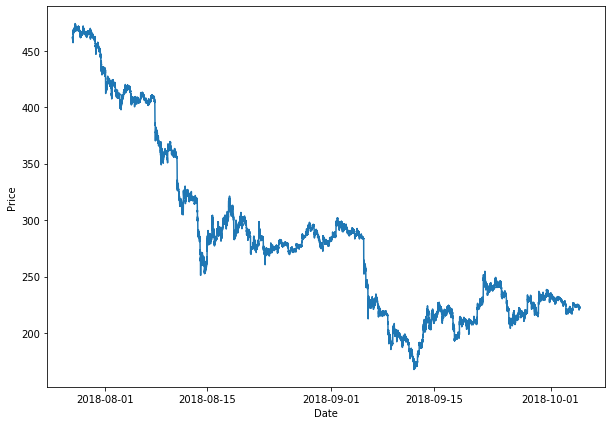

In [5]:
# Let us visualize the data to confirm if it really was trending for the given time frame
plt.figure(figsize=(10, 7))
plt.plot(df1.Close)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### Compute the rolling hurst values

In [6]:
df1['H'] = 0

### The execution of the cell below will take around 5 -10 minutes. If you want a faster execution, please reduce the data size from 100000 to 1000 in Cell 3, and then rerun all the cells.

#### We are using the past 4 hour data to calculate the hurst exponent.

In [7]:
for i in range(240, len(df1)):
    df1.iloc[i, df1.columns.get_loc('H')] = compute_Hc(
        df1.Close.iloc[i-240:i-1], kind='price')[0]

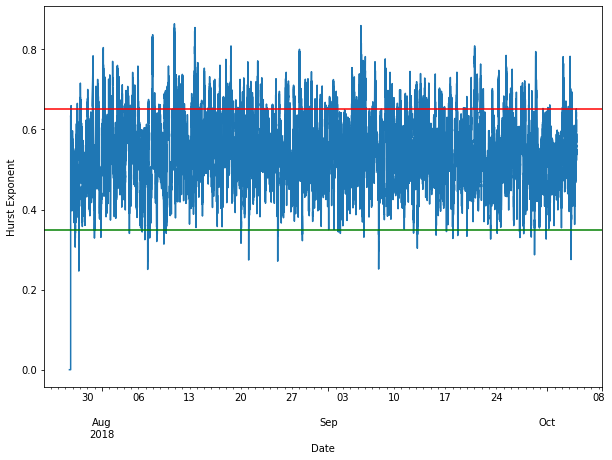

In [8]:
# Let us plot the hurst values to visualize it
# We will be using threshold values of 0.65 and 0.35 to avoid trading for the noise
plt.figure(figsize=(10, 7))
df1.H.plot()
plt.axhline(0.35, color='g')
plt.axhline(0.65, color='r')
plt.xlabel('Date')
plt.ylabel('Hurst Exponent')
plt.show()

### Generate the persitence signals

In [9]:
df1['Signal'] = 0
df1['Signal'] = np.where(df1.H > 0.65, 1, df1.Signal)
df1['Signal'] = np.where(df1.H < 0.35, -1, df1.Signal)

### Compute the RSI 

In [10]:
df1['RSI'] = ta.RSI(df1.Close.shift(1).values, 14)

### Compute the market return

In [11]:
# Since we use the previous Close price to calculate the RSI and Hurst values, we use the close prices to calculate
# the market returns during the execution of the strategy.
df1['Return'] = df1.Close.pct_change()

### Compute the strategy returns

We use RSI here to gauge the overbought/oversold condition of the market.

We <font color=blue>buy</font>  when

1. RSI is more than 75 and Persistence signal is 1
2. RSI is less than 25 and Persistence signal is -1

We <font color=red>sell</font>  when

1. RSI is more than 75 and Persistence signal is -1
2. RSI is less than 25 and Persistence signal is 1

In [12]:
df1['StrReturn'] = 0

df1['StrReturn'] = np.where(
    ((df1.RSI > 75) & (df1.Signal == -1)), -df1.Return, df1.StrReturn)

df1['StrReturn'] = np.where(
    ((df1.RSI < 25) & (df1.Signal == -1)), df1.Return, df1.StrReturn)

df1['StrReturn'] = np.where(
    ((df1.RSI > 75) & (df1.Signal == 1)), df1.Return, df1.StrReturn)

df1['StrReturn'] = np.where(
    ((df1.RSI < 25) & (df1.Signal == 1)), -df1.Return, df1.StrReturn)

### Compute the total slipapge cost

In [13]:
# When we execute a strategy based on market orders our strategy can experience a significant slippage,
# if the bid-ask prices are far away. So, we have taken an average bid-ask spread of 0.05 based on the orderbook
# data from cryptoexchanges.

total_slippage_cost = len(df1[df1.StrReturn != 0])*0.05/df1.Close.mean()
total_slippage_cost

0.12242743305187771

In [14]:
Cumulative_Returns = df1.StrReturn.cumsum()

### Plot the cumulative returns of the strategy

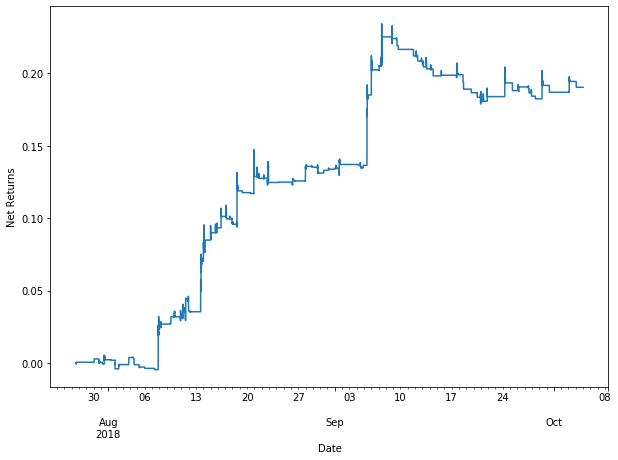

In [15]:
plt.figure(figsize=(10, 7))
Cumulative_Returns.plot()
plt.xlabel('Date')
plt.ylabel('Net Returns')
plt.show()

### Compute the net profit after slippage

In [16]:
Final_percentage_retuns = (Cumulative_Returns.iloc[-1]-total_slippage_cost)*100

In [17]:
Final_percentage_retuns

6.805456409238202

In the next section, there will be interactive exercises and quizzes. All the Best! <br><br>